# Identificando Entidades Nomeadas e Similaridade Semântica
Neste capítulo vamos treinar um *identificador de entidades  nomeadas* (NER - Named Entity Recognizer) usando a biblioteca [Spacy](https://spacy.io). A partir deste capítulo vamos importar também funções que já criamos anteriormente, e que encontram-se reproduzidas em  [dhbbmining.py](dhbbmining.py).

In [110]:
import warnings
warnings.filterwarnings('ignore')

In [111]:
import os, glob, pickle
import spacy
from IPython.core.display import display, HTML, Markdown
from spacy import displacy
from sqlalchemy import create_engine
from dhbbmining import *
import ipywidgets as widgets

Para utilizar o spacy em um corpus na lingua portuguesa, vamos primeiro importar o modelo liguístico do português

In [ ]:
!python3 -m spacy download pt_core_news_sm

In [114]:
nlp = spacy.load("pt_core_news_sm")

Em seguida podemos carregar os verbetes biográficos que salvamos no nosso banco SQLite.

In [115]:
eng = create_engine("sqlite:///minha_tabela.sqlite")
biograficos = pd.read_sql_query('select * from resultados', con=eng)
biograficos.head()

,index,arquivo,title,natureza,sexo,cargos,corpo
0,0,6172.text,PARTIDO POPULAR DO DISTRITO FEDERAL,temático,None,NA,\n\n«PARTIDO POPULAR DO DISTRITO FEDERAL»\n\nP...
1,1,4361.text,"PRATES, Mílton",biográfico,m,\n - const. 1946\n - dep. fed. MG 1946-1951 \n,\n\n«Luís Mílton Prates» nasceu em Montes Clar...
2,2,5224.text,"SUREK, Alberto",biográfico,m,\n - const. 1934\n - dep. fed. prof. 1935-193...,\n\n«Alberto Surek» nasceu em Araucária (PR) n...
3,3,5039.text,"SILVA, Luís Gonzaga do Nascimento e",biográfico,m,\n - pres. BNH 1965-1966\n - min. Trab. 1966-...,\n\n«Luís Gonzaga do Nascimento e Silva» nasce...
4,4,6193.text,PARTIDO REFORMADOR TRABALHISTA (PRT),temático,None,NA,\n\n«PARTIDO REFORMADOR TRABALHISTA (PRT)»\n\n...


Apesar de nomearmos nosso DataFrame "Biográficos", existe uma outra natureza de verbete neste corpus, os verbetes temáticos. Vejamos um exemplo:

In [120]:
print(biograficos[biograficos.natureza=='temático'].iloc[2].corpo[:1500])



«DIÁRIO CARIOCA»

Jornal carioca diário fundado em 17 de julho de 1928 por José Eduardo de
Macedo Soares e extinto em 31 de dezembro de 1965.

## De 1928 a 1934

O «Diário Carioca» nasceu com a finalidade precípua de fazer oposição ao
governo de Washington Luís. Seu fundador, de tradicional família
fluminense, havia saído da Marinha para a política e posteriormente para
a imprensa, abandonando a carreira militar no posto de primeiro-tenente.
Fundara em 1912 «O Imparcial». Embora suas atividades políticas durante a
República Velha estivessem vinculadas ao poder institucionalizado, a
partir de dado momento Macedo Soares passou a refletir uma das correntes
de oposição à estrutura política vigente. Tanto isto é verdade que o
primeiro número do «Diário Carioca» deveria ter saído a 5 de julho, para
comemorar o sexto aniversário do levante dos 18 do Forte.

Ao lado do fundador, que reservou para si a diretoria, o novo jornal
contava em sua equipe inicial com Alberto Burle de Figueiredo na
g

Para começar a utilizar o Spacy, precisamos primeiro precisamos processar o texto. Nesta passagem várias análises linguísticas são realizadas.

In [7]:
doc = nlp(biograficos.corpo[0].strip())
type(doc)

spacy.tokens.doc.Doc

Vejamos os descritores disponíveis para cada token.

In [8]:
for i, token in enumerate(doc):
    print(f"Texto:{token.text},\n Lemma: {token.lemma_},\nPart of speech: {token.pos_},\nTag: {token.tag_}, \nDep:{token.dep_},\
            Shape:{token.shape_}, \nAlpha? {token.is_alpha}, \nStopword:{token.is_stop}\n")
    if i>2:
        break
    

Texto:«,
 Lemma: «,
Part of speech: PUNCT,
Tag: PUNCT, 
Dep:punct,            Shape:«, 
Alpha? False, 
Stopword:False

Texto:PARTIDO,
 Lemma: PARTIDO,
Part of speech: PROPN,
Tag: PROPN, 
Dep:ROOT,            Shape:XXXX, 
Alpha? True, 
Stopword:False

Texto:POPULAR,
 Lemma: POPULAR,
Part of speech: PROPN,
Tag: PROPN, 
Dep:flat:name,            Shape:XXXX, 
Alpha? True, 
Stopword:False

Texto:DO,
 Lemma: De O,
Part of speech: ADP,
Tag: ADP, 
Dep:case,            Shape:XX, 
Alpha? True, 
Stopword:True



## Testando o NER do Spacy
Como o Spacy já inclui algum suporte à lingua portuguesa, antes de pensar em treinar nosso próprio NER, podemos avaliar a performance do existente. 

Abaixo vamos construir uma visualização interativa da marcação de entidades nos verbetes do DHBB.

In [50]:
from IPython.display import display,clear_output, HTML
from ipywidgets import interact

In [10]:
@interact(e=(0, len(biograficos)))
def mostra_ner(e=0):
    text = biograficos.iloc[e].corpo.strip()
    doc = nlp(text)
    displacy.render(doc, style="ent", jupyter=True)
    clear_output(wait=True)

interactive(children=(IntSlider(value=0, description='e', max=7687), Output()), _dom_classes=('widget-interact…

Além da visualização, podemos extrair as entidades presentes em um verbete:

In [11]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

PARTIDO POPULAR DO 1 19 ORG
Partido 39 46 ORG
Rio de Janeiro 59 73 LOC
Distrito Federal 81 97 LOC
João Câncio da Silva 134 154 PER
Assembléia Nacional Constituinte 177 209 ORG
Américo Basílio Silvado 253 276 PER
Henrique de Toledo
Dodsworth 278 306 PER
Amélio Dias de Morais 308 329 PER
Adolfo Bergamini 331 347 PER
Jones Gonçalves
Rocha 349 370 PER
José Matoso de Sampaio 372 394 PER
Antenor Esposel Coutinho 404 428 PER
Inácio
Bittencourt 430 448 PER
Berta Lutz 450 460 PER
Georgina de Araújo 463 481 PER


O NER incluído no Spacy não é muito preciso, como podemos ver. Mas podemos treinar uma versão melhorada seguin as [instruções da documentação do Spacy](https://spacy.io/usage/training#basics)

Podemos ainda ver que tipos de entidades o Spacy reconhece:

In [12]:
set([ent.label_ for ent in doc.ents])

{'LOC', 'ORG', 'PER'}

# Similaridade Semântica
Outra análise interessante que pode ser feita sobre os verbetes do DHBB é a de similaridade semântica. Este tipo de análise se baseia em modelos vetoriais tipo "word2vec", que representam palavras de um corpus em um espaço semântico.
Podemos aplicar o modelo pré-treinado do Spacy como exemplo, mas idealmente deve-se treinar estes modelos em corpora similares ao que se deseja analizar ou no próprio, como faremos no capítulo 5 deste livro.

In [81]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

Construir uma rede de verbetes similares usando a uma comparação de pares de documentos é uma abordagem muito ineficiente, por isso no exemplo abaixo vamos nos restringir a 20 comparações.

In [85]:
G = nx.Graph()

for i,verb1 in tqdm(enumerate(biograficos.itertuples())):
    for j,verb2 in enumerate(biograficos.itertuples()):
        if j>=i:
            continue
        doc1 = nlp(verb1.corpo)
        doc2 = nlp(verb2.corpo)
        sim = doc1.similarity(doc2)
        # print(sim)
        if sim > 0.8:
            G.add_edge(verb1.title, verb2.title, weight=sim)
    if len(G.nodes)>20:
        break
            

20it [01:02,  3.14s/it]


O grafo resultante, é formado por 21 nós representando cada verbete e arestas representando a similaridade entre cada par.

In [86]:
G.order()

21

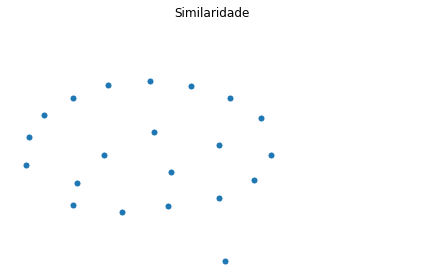

In [107]:
connected = [n for n, d in G.degree() if d > 0]
fig, ax = plt.subplots()
# Identifica verbetes conectados
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
#### desenha grafo ####
pos = nx.nx_agraph.graphviz_layout(G)
ax.set_title(f"Similaridade")
# desenha aresta
options = {"ax": ax, "edge_color": "red"}
nx.draw_networkx_edges(G0, pos, width=6, **options);
# desenha nós
options = {"ax": ax, "node_size": 50, "edgecolors": "white"}
nx.draw(G, pos, nodelist=connected, **options)
fig.tight_layout()

In [101]:
nx.write_gexf(G0,'dhbb.gexf')